# Stoneburner, Kurt
- ## DSC 530 - Week 11

In [1]:
####################################################
####################################################
####################################################
####//*** Reused Functions from previous exercises
####################################################
####################################################
####################################################
# //*****************************************
# //*** Build a probability mass function
# //*****************************************
# //*** Returns Series as a PMF
# //*****************************************
def build_pmf(input_series):
    output_series = input_series.copy()
    total_values = input_series.sum()
    for value,freq in output_series.items():
        #print(f"{value} {freq} {total_values} {freq/total_values}")
        output_series.loc[value] = freq/total_values
    return output_series

# //*** Build a Cumulative Distribution Function from a Probability Mass Function
# //*** Returns a Series
def build_cdf(input_series):
    # //*** If input is not panda or pd series, try to convert it
    if not isinstance(input_series,pd.core.series.Series):
        input_series = pd.Series(input_series)
        
    # //*** If input is np.Array
    output_series = input_series.copy()
    cumulative_value = 0
    for value,freq in output_series.items():
        #print(f"{value} {freq} {cumulative_value} {freq + cumulative_value}")
        cumulative_value = freq + cumulative_value
        output_series.loc[value] = cumulative_value
    return output_series

# //*** Retrieve a percentile value from a CDF.
# //*** Returns index value closest to input parameter percentile.
def get_cdf_percentile(input_cdf,percentile):
    #print(f"{input_cdf}")
    #//*** Initialize output to first value
    output = input_cdf.index[0]
    
    #//*** Loop through all items till the value exceeds the percentile
    #//*** Return value from last loop
    for index,value in input_cdf.items():
        
        if value > percentile:
            return output
        else:
            output = index

# //**** Legends automatically generate too many labels.
# //**** Function eliminates the duplicates
def deduplicate_legend(input_ax):
    # //**** Get handle and label list for the current legend
    # //**** Use first instance, toss the rest.
    handles, labels = input_ax.get_legend_handles_labels()

    handle_dict = {}

    for x in range(len(labels)):
        if labels[x] not in handle_dict.keys():
            # //*** Label = handle
            handle_dict[labels[x]] = handles[x]

    # //*** Build unique output ists and handles
    out_handles = []
    out_labels = []
    
    for label,handle in handle_dict.items():
        out_handles.append(handle)
        out_labels.append(label)
    
    return out_handles,out_labels
####################################################
####################################################
####################################################
####//*** END Functions from previous exercises
####################################################
####################################################
####################################################

In [2]:
####################################################
####################################################
####################################################
####//*** Thinkstats function
####################################################
####################################################
####################################################
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10
    
    resp.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
    resp['agemarry'] = (resp.cmmarrhx - resp.cmbirth) / 12.0
    resp['age'] = (resp.cmintvw - resp.cmbirth) / 12.0

In [3]:
####################################################
####################################################
####################################################
####//*** New Functions for this week
####################################################
####################################################
####################################################
# def build_hazard_function(sf):
#-------- Takes a survival function and returns a hazard Function
###################################################################
# build_kaplan_meier_hazard_curve(input_complete, input_ongoing):
#--------- Generates an estimates the longevity of a 
#--------- population and returns a hazard function 
###################################################################
# build_survival_from_hazard(input_hazard_series):
#--------- Builds Survival Function from a hazard function 
###################################################################
#//*** Build hazard function from a cdf
#//*** Hazard Function: (1-CDF(x)) - (1-CDF(x+1)) / (1-CDF(x))
#//*** Difference between a value and the next value (ie the difference in two values) divided by the first value
#//*** This is a percentage of difference between sequential survivor function (1-CDF[x]) values
#//**** Returns a dictionary of hazard values
###################################################################
def build_hazard_function(sf):
    #//*** Convert cdf to survival function
    #sf = 1 - pd.Series(input_cdf)
    
    #//*** output dictionary
    out_dict= {}
    
    for index,value in enumerate(sf):
        #//*** Skip the last value since it generates an out of array error.
        #//*** Had troubles parsing a series len(-1) so did it this way
        if index < len(sf)-1:
            if sf.iloc[index] != 0:
                #//*** Value = Hazard Value
                out_dict[value] = ( sf.iloc[index] - sf.iloc[index+1] / sf.iloc[index] )
            else:
                out_dict[value] = 0
    return out_dict

#//*** Build a Kaplan Meier Survival Curve to estimate a survival function
#//*** For an estimated/predicted lifetime

def build_kaplan_meier_hazard_curve(input_complete, input_ongoing):
    #//*** Build Histogram Dictionary of Complete and ongoing
    #//*** No reason to import a Counter Library for Basic stuff
    #//*** Usual histogram method of value_counts and sort_index, combined with a for items loop
    #//*** to convert to a dictionary
    from collections import Counter    
    hist_complete_counter = Counter(input_complete)
    hist_ongoing_counter =  Counter(input_ongoing)
    hist_combined_list = []    

    hist_complete = {}
    for index, value in input_complete.value_counts().sort_index().items():
        #//*** Add Unique value to the combined list
        if index not in hist_complete.keys():
            hist_combined_list.append(index)

        #//*** Add to Dictionary
        hist_complete[index] = value

    hist_ongoing = {}
    for index, value in input_ongoing.value_counts().sort_index().items():
        #//*** Add Unique value to the combined list
        if index not in hist_complete.keys():
            hist_combined_list.append(index)

        #//*** Add to Dictionary
        hist_ongoing[index] = value

    #hist_combined_list = list(hist_complete_counter | hist_ongoing_counter)
    hist_combined_list.sort()
    
    at_risk = len(input_complete) + len(input_ongoing)
    

    #//*** Create an empty Survival curve using the hist_comibined_list as a key
    #//*** All values will be represented in the Survival Curve.
    #//*** If something is missed it will be represented as a NaN
    survival_curve = pd.Series(index=hist_combined_list,dtype='float')

    #//*** Go through each value in the ongoing and complete dictionaries
    #//*** Get the count of each, or zero if not found
    for x in hist_combined_list:
        

        
        if x in hist_complete.keys():
            ended = hist_complete[x]
        else:
            ended = 0

        if x in hist_ongoing.keys():
            censored = hist_ongoing[x]
        else:
            censored = 0
        
        ended = hist_complete_counter[x]
        censored = hist_ongoing_counter[x]

        #//*** Calculate the percentage of ended vs the remaining at risk
        survival_curve[x] = ended / at_risk

        
        #//*** Reduced the at_risk total by the totals found
        at_risk -= ended + censored

    return survival_curve

def build_survival_from_hazard(input_hazard_series):
    #//****************************************************
    #//**** Convert Hazard Function to Survival Function
    #//****************************************************
    ts = input_hazard_series.index
    #//*** cumprod - cumulative product. Essentially builds a CDF from hazard curve
    #//**** (1-hazard_curve).cumprod() Survival Function (reciprocal CDF) of hazard curve
    sf = (1 - input_hazard_series).cumprod()
    #//****************************************************
    
    return (pd.Series(index=ts, data=sf))  

In [4]:
# //****************************************************************************************
# //*** Set Working Directory to thinkstats folder.
# //*** This pseudo-relative path call should work on all Stoneburner localized projects. 
# //****************************************************************************************

import os
import sys
workingPath = os.getcwd().replace("coding", "ThinkStats2\\code")
sys.path.insert(1, workingPath)
os.chdir(workingPath)

In [5]:
# //*** Imports and Load Data
import nsfg
import thinkstats2
import thinkplot
import first
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random


**Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [6]:
#//****************************************
#//*** Prepare, Clean and load the data
#//****************************************

#//*** Import data sets
resp6 = nsfg.ReadFemResp(dct_file='2002FemResp.dct',dat_file='2002FemResp.dat.gz')
resp7 = nsfg.ReadFemResp(dct_file='2006_2010_FemRespSetup.dct',dat_file='2006_2010_FemResp.dat.gz')

#//*** Clean Data using included Thinkstsats code
CleanData(resp6)
CleanData(resp7)

#//*** Combine 2002 and 2010 datasets
resp = pd.concat([resp6,resp7], sort=False)#resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)

#//*** There are a number of coding errors with durationsofar. A few marriages and divorces are listed 
#//*** are negative lengths. Drop these rows
resp.drop(index=resp[ resp['durationsofar'] <= 0 ].index, inplace=True)
resp.drop(index=resp[ resp['duration'] <= 0 ].index, inplace=True)


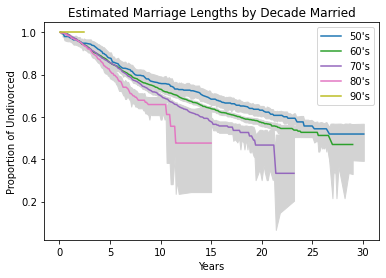

In [7]:
#//*** Process just the respondants who are married
married = resp[resp.evrmarry==1]

#//*** Ground the respondants into cohorts by decade
cohorts = married.groupby('decade')

#//*** Matplotlib labeling 
labels = []
fig,ax = plt.subplots()

#//*** Build a survival function and resampled error estimate for each cohort
for cohort in cohorts:

    #//*********************************************
    #//*** Build Survival Function for each cohort
    #//*********************************************
    
    #//*** ongoing is a list of those married and not divorced (yet!)
    ongoing = round(cohort[1][cohort[1].notdivorced==1]['durationsofar'].dropna(),1)
    #//*** complete is a list of marriages that have ended
    complete = round(cohort[1][cohort[1].notdivorced==0]['duration'].dropna(),1)

    #//*** Build Kaplan Meir Hazard Estimate
    hazard_curve = build_kaplan_meier_hazard_curve(complete,ongoing)
    
    #//*** Generate a survival Curve from the hazard Curve
    sf = build_survival_from_hazard(hazard_curve)
    
    #//*** Build a reciprocal CDF from the survival function
    sf_cdf = 1-sf

    #//*********************************************************************************************************
    #//*** BEGIN RESAMPLING: ideally this would be abstracted to a function that returns the interval values
    #//*********************************************************************************************************
    
    #//*** Generate weighted samples
    complete_len = len(complete)
    ongoing_len = len(ongoing)
    resampled_survival_curves = []
    ci_dict = {}
    
    #//*** Build 100 random resamples
    for _ in range(100):
        #//*** There aren't enough values to generate error intervals for the 90's decade. Skip error intervals for this decade
        if len(complete) == 0:
            break

        #//*** Generate random weighted percentages with the range of the CDF.
        complete_weight = [ random.uniform(sf_cdf.min(),sf_cdf.max()) for __ in range(complete_len) ]
        ongoing_weight = [ random.uniform(sf_cdf.min(),sf_cdf.max()) for __ in range(ongoing_len) ]
        
        #//*** Convert List of Random weights into values from the CDF.
        complete_resample = pd.Series(random.choices(list(complete),weights=complete_weight,k=complete_len))
        ongoing_resample = pd.Series( random.choices(list(ongoing),weights=ongoing_weight, k=ongoing_len) )
        
        #//*** Build Estimated Lifetime Hazard Function from resampled/random data
        resample_hazard_curve = build_kaplan_meier_hazard_curve(complete_resample,ongoing_resample)

        #//*** Convert Hazard Function to Survival Function
        re_sample_ts = resample_hazard_curve.index
        re_sample_ss = (1 - resample_hazard_curve).cumprod()
        loop_series = pd.Series(index=re_sample_ts, data=re_sample_ss)
        
        
        #//*** Collect Values for each index over all resamples
        #//*** Build a dictionary that contains resampled survival values for each marriage length. 
        #//*** This represents an ranbdom error range for each value.
        for x in loop_series.index:
            #//*** New key initialize
            if x not in ci_dict.keys():
                ci_dict[x] = [loop_series[x]]
            else:
                #//*** Existing key append
                ci_dict[x].append(loop_series[x])
    #//*** Get resampled Hi/Low (error) for each value. This represents the resampled error for each value
    min_vals = []
    max_vals = []

    resample_index = list(ci_dict.keys())
    resample_index.sort()
    for x in resample_index:
        loop_value_counts = pd.Series(ci_dict[x]).value_counts().sort_index()
        loop_cdf = build_cdf(build_pmf(loop_value_counts))
        min_vals.append(get_cdf_percentile(loop_cdf,.025) )
        max_vals.append(get_cdf_percentile(loop_cdf,.975) )
    
    #//****************************
    #//*** END RESAMPLING
    #//****************************
    
    #//*** Build Labels for plotting
    decade_label = str(cohort[0]) +"0's"
    labels.append(decade_label)
    
    #//*** Plot the predicted error based on ranges of random samples.
    plt.fill_between(resample_index, min_vals, max_vals,color='#D3D3D3')
    
    #//*** Add to Plot the Estimated Survival function for the decade
    ax.plot(sf.index,sf,1,label = decade_label)
    
#//*******************    
#//*** Draw Final Plot
#//*******************
handles,labels = deduplicate_legend(ax)    
plt.legend(handles,labels)
plt.title(f"Estimated Marriage Lengths by Decade Married")
ax.set_ylabel('Proportion of Undivorced')
ax.set_xlabel('Years')
plt.show()
